In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# OBSERVADOR DE ESTADO DE ORDEM PLENA

In [2]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [3]:
s = ctl.TransferFunction.s

G = 1/(s*(s+1)*(s+2))
G

TransferFunction(array([1]), array([1, 3, 2, 0]))

polos:  (-2+0j) (-1+0j) 0j
zeros: 


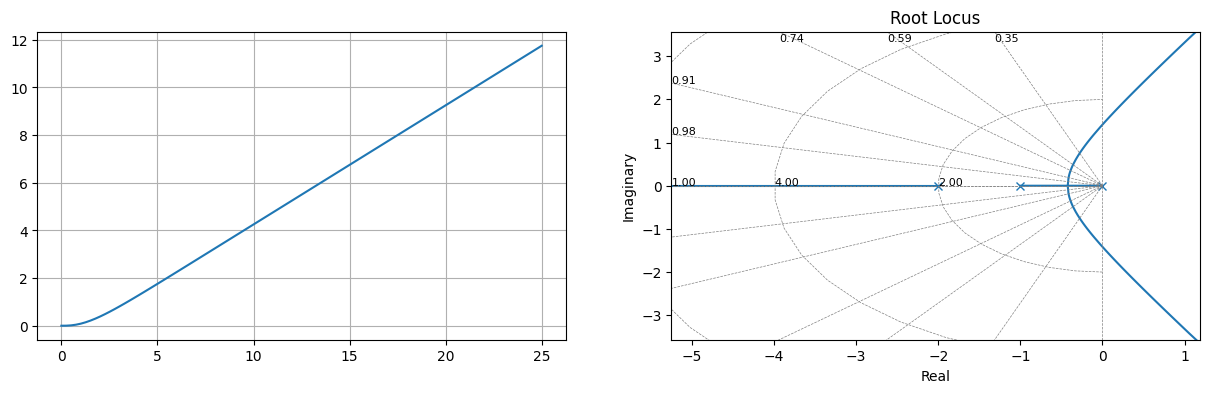

In [4]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# REQUISITOS DE CONTROLE

In [5]:
Ts = 1.00
UP = 0.20

- $\zeta = -\frac{ln(UP\%)}{\sqrt{\pi² + ln²(UP\%)}}$

In [6]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.4559498107691261

- $\omega_n = \frac{4}{\zeta\,t_s}$ 

In [7]:
Wn = 4/(zeta*Ts)
Wn

8.772895405423103

- $s_d = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [8]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*1j
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*1j
s3 = -10                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s4 = -10                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)

p = [np.round(val, 2) for val in [s1, s2, s3, s4]]
p

[(-4+7.81j), (-4-7.81j), -10, -10]

# ESPAÇO DE ESTADOS
- Forma padrão (computacional)

In [9]:
matrix = ctl.tf2ss(G)
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[-3.0, -2.0, 0],
[ 1.0,    0, 0],
[   0,  1.0, 0]])

Matrix([
[1.0],
[  0],
[  0]])

Matrix([[0, 0, 1.0]])

Matrix([[0]])

- Forma variáveis de fase (convencional)

In [10]:
def getVariaveisFase(G):
    matrix = ctl.tf2ss(G)
    A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
    
    n = A.shape[0]

    # Cria uma matriz P com elementos 1 na diagonal secundária
    P = np.fliplr(np.eye(n))

    # Calcula a inversa da matriz P
    P_inv = np.linalg.inv(P)

    # Realiza as operações para obter a forma de variáveis de fase
    A = P_inv @ A @ P
    B = P_inv @ B
    C = C @ P
    D = D
    
    return A, B, C, D

A, B, C, D = getVariaveisFase(G)
display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[0,  1.0,    0],
[0,    0,  1.0],
[0, -2.0, -3.0]])

Matrix([
[  0],
[  0],
[1.0]])

Matrix([[1.0, 0, 0]])

Matrix([[0]])

In [11]:
n = sp.shape(A)[0]
n

3

# CONTROLADOR

In [12]:
K = ctl.acker(A, B, p)
#K = ctl.place(A, B, p)

sp.Matrix(K)

Matrix([[7699.61, 2289.922, 259.9961]])

In [13]:
L = ctl.acker(A.T, C.T, p).T
#L = ctl.place(A.T, C.T, p).T

sp.Matrix(L)

Matrix([
[ 259.9961],
[1509.9337],
[2649.8167]])

In [14]:
s = sp.symbols('s')
I = sp.eye(n) 
A, B, C, D = sp.Matrix(A), sp.Matrix(B), sp.Matrix(C), sp.Matrix(D)

- O controlador é obtido usando $C(s) = K(sI-A + LC + BK)^{-1}L$

In [15]:
C = K*(s*I - A + L*C + B*K).inv()*L
C = C[0].expand().simplify().factor().cancel()
C = roundSympyFunction(C)
C

(0.0017*s**6 + 0.0509*s**5 + 0.7755*s**4 + 6.2776*s**3 + 27.4516*s**2 + 62.0255*s + 59.0862)/(0.0008*s**4 + 0.0134*s**3 + 0.1224*s**2 + 0.5602*s + 1.0)

# RESPOSTA CONTROLADA

In [16]:
s = ctl.TransferFunction.s
C = eval(str(C))
C

TransferFunction(array([1.70000e-03, 5.09000e-02, 7.75500e-01, 6.27760e+00, 2.74516e+01,
       6.20255e+01, 5.90862e+01]), array([8.000e-04, 1.340e-02, 1.224e-01, 5.602e-01, 1.000e+00]))

In [17]:
G_ma = G*C
G_ma

TransferFunction(array([1.70000e-03, 5.09000e-02, 7.75500e-01, 6.27760e+00, 2.74516e+01,
       6.20255e+01, 5.90862e+01]), array([8.0000e-04, 1.5800e-02, 1.6420e-01, 9.5420e-01, 2.9254e+00,
       4.1204e+00, 2.0000e+00, 0.0000e+00]))

In [18]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([1.70000e-03, 5.09000e-02, 7.75500e-01, 6.27760e+00, 2.74516e+01,
       6.20255e+01, 5.90862e+01]), array([8.00000e-04, 1.75000e-02, 2.15100e-01, 1.72970e+00, 9.20300e+00,
       3.15720e+01, 6.40255e+01, 5.90862e+01]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

In [19]:
[np.round(val, 3) for val in list(ctl.poles(G_feedback))]

[(-2.219+7.259j),
 (-2.219-7.259j),
 (-2.921+3.248j),
 (-2.921-3.248j),
 (-4.204+0j),
 (-3.695+1.524j),
 (-3.695-1.524j)]

polos:  (-2.219+7.259j) (-2.219-7.259j) (-2.921+3.248j) (-2.921-3.248j) (-4.204+0j) (-3.695+1.524j) (-3.695-1.524j)
zeros:  (-7.534+9.479j) (-7.534-9.479j) (-4.709+1.468j) (-4.709-1.468j) (-2.728+1.518j) (-2.728-1.518j)


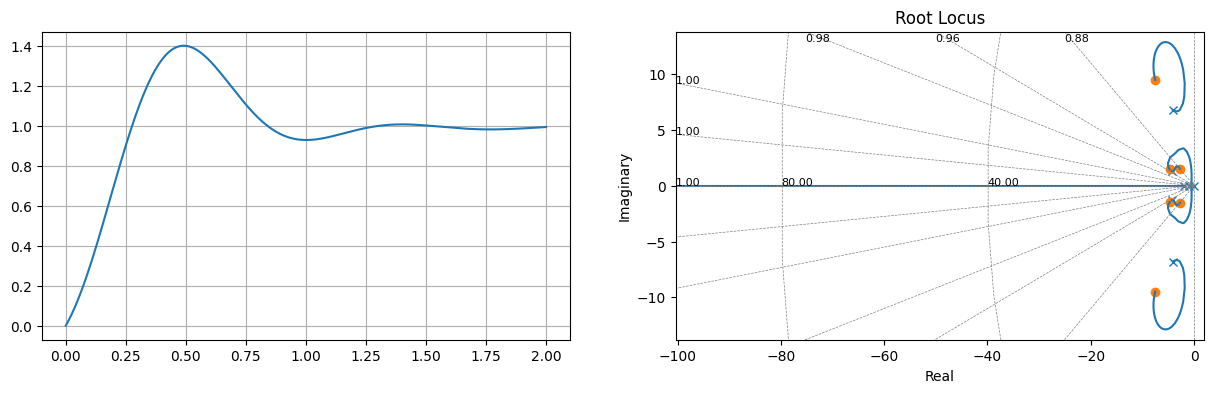

In [20]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G_feedback, T=np.linspace(0, 2*Ts, 1000))
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [21]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.4091069744071079
valor de pico:  1.4024962912679575
tempo de pico:  0.4904904904904905
tempo de assentamento:  1.1851851851851851
valor final:  0.9953086009371773
erro:  0.0046913990628226765


# APLICANDO VÁRIOS STEPS

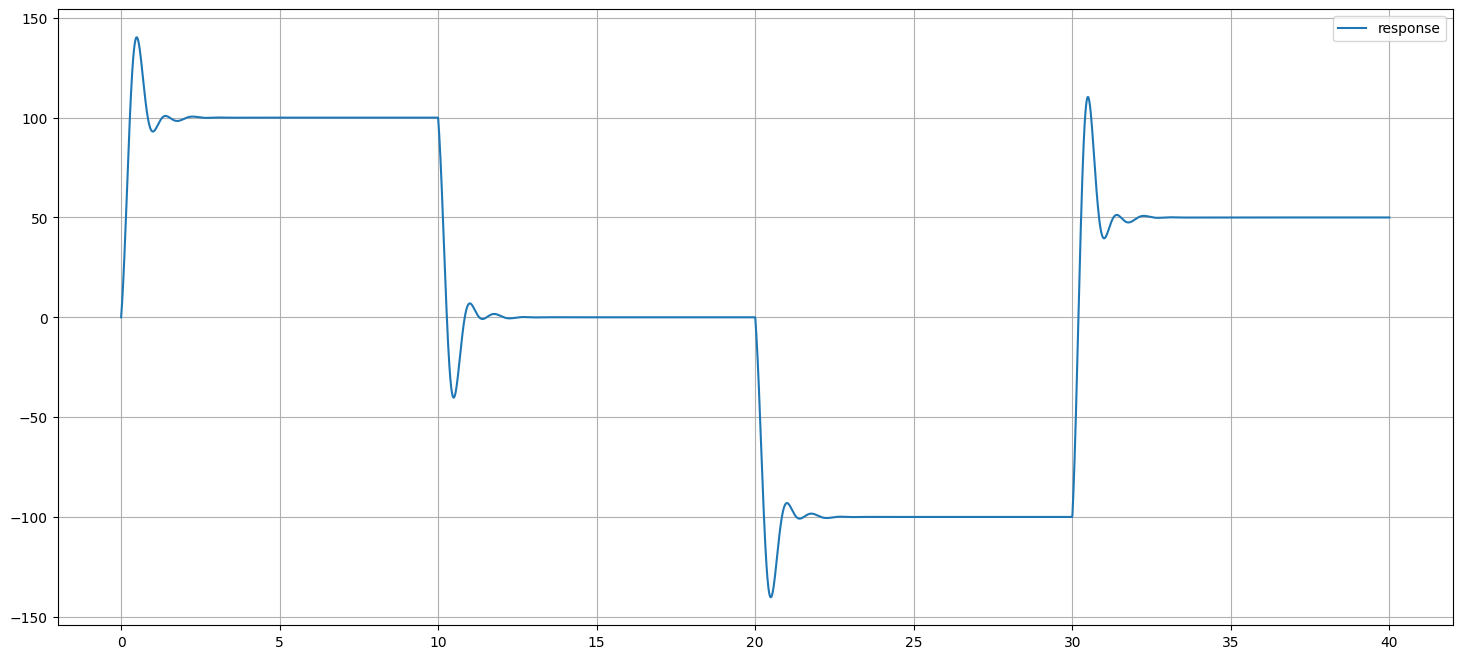

In [22]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()